## Imports

In [2]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
!pip install pyLDAvis

  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 39.7 MB/s eta 0:00:00
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2


In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [4]:
# Para el error raro de gensim
#!pip uninstall -y scipy
#!pip install --no-cache-dir scipy

Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 174.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.2 which is incompatible.


In [3]:
import os
import re
import spacy
import html
import numpy as np
import pandas as pd
import gensim.downloader
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns

from wordcloud import WordCloud
from gensim import corpora, models
from gensim.models import KeyedVectors, LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from transformers import pipeline
from tqdm import tqdm
from datasets import Dataset
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

## Data loading

In [4]:
filename = "boardgames_3000.csv"
df = pd.read_csv(filename, sep=";")
df.head()

,id,name,description,year,rating,complexity,minplayers,maxplayers,playingtime,minage,categories
0,1,Die Macher,Die Macher is a game about seven sequential po...,1986,7.58777,4.3081,3,5,240,14,"Economic, Negotiation, Political"
1,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,6.66468,1.9643,3,4,30,12,"Card Game, Fantasy"
2,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,7.47596,2.4420,2,4,60,10,"Abstract Strategy, Medieval"
3,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,6.61540,2.6875,2,4,60,12,Ancient
4,5,Acquire,"In Acquire, each player strategically invests ...",1964,7.35053,2.4923,2,6,90,12,"Economic, Territory Building"


## Task 1: Text Preprocessing and vectorization

### Text Preprocessing

In [5]:
# Load English spaCy model
nlp = spacy.load("en_core_web_sm")

custom_stopwords = {"s", "quot"}

def clean_text(text):
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Apply spaCy NLP processing
    doc = nlp(text)

    # Remove stopwords, lemmatize, exclude punctuations, and custom words
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and token.is_alpha and token.lemma_ not in custom_stopwords
    ]

    return " ".join(tokens)

In [6]:
# Apply the cleaning function to all descriptions
df["clean_description"] = df["description"].apply(clean_text)

In [7]:
# Example: original and cleaned text for first entry
print("Original:\n", df["description"][0])
print("Cleaned:\n", df["clean_description"][0])

Original:
 Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Second, if a party wins a regional election and has some media influence in the region, then the party will receive some media-control victory points. Third, each party has a national party membership which will grow as the game progresses and this will supply a fair number of victory points. Lastly, parties score some victory points if their party platform matches the national opinions at the end of the game.&#10;&#10;The 1986 edition featured four parties from the old West Germany and

#### Save clean dataset (if desired)

In [8]:
df.to_csv("boardgames_3000_clean.csv", index=False, encoding="utf-8", sep=";")

### Vectorization

#### BoW and TF-IDF

In [9]:
# For this task, we will mainly be working with the column "clean_description".
# We will tokenize this part fist
tokenized_descr = [clean_description.split() for clean_description in df["clean_description"]]

In [10]:
# Then we will create a dictionary and obtain both the BoW corpus and the TF-IDF corpus
# BoW corpus
dictionary = corpora.Dictionary(tokenized_descr)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_descr]

# TF-IDF corpus
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

Now we would like to obtain some insights from our data using the TF-IDF corpus. However, we cannot use it as it is. `tfidf_corpus`is a sparse corpus matrix, not a dense numpy matrix.

Gensim is optimized for streaming large corpora and if we wanted to do some visualizations, we would need to convert it to dense form.

In [11]:
num_docs = len(tfidf_corpus)
num_terms = len(dictionary)

# Create empty matrix
X_tfidf_gensim = np.zeros((num_docs, num_terms))

# Fill it with TF-IDF scores
for doc_idx, doc in enumerate(tfidf_corpus):
    for term_id, tfidf_score in doc:
        X_tfidf_gensim[doc_idx, term_id] = tfidf_score

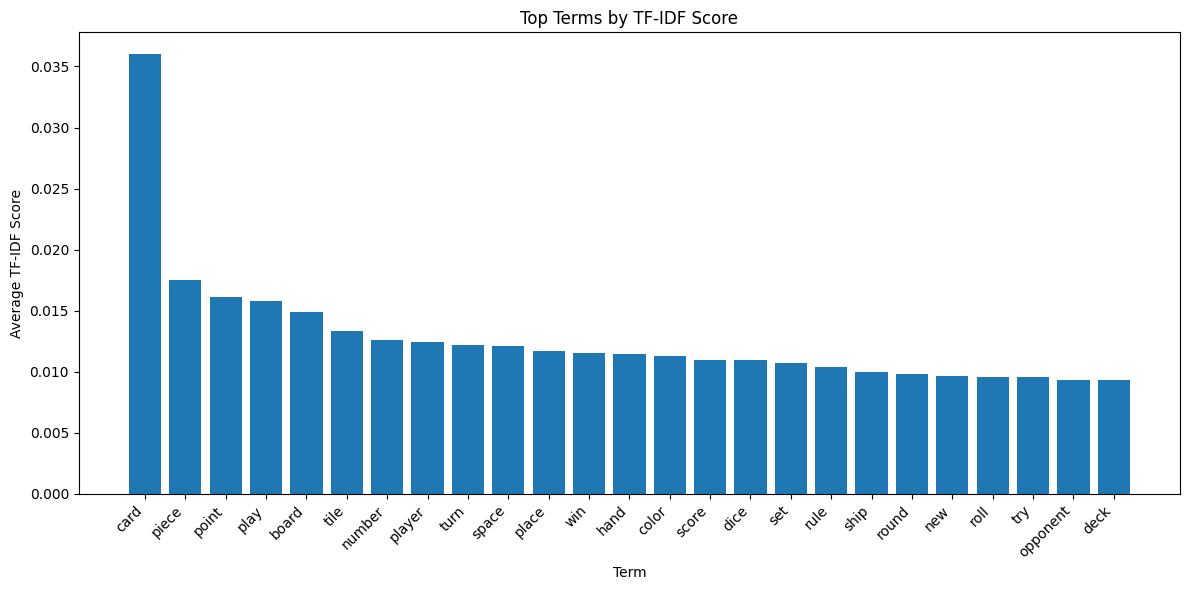

In [12]:
# Compute average TF-IDF per term
avg_tfidf_scores = X_tfidf_gensim.mean(axis=0)

# Top-N terms
top_n = 25
top_term_indices = avg_tfidf_scores.argsort()[::-1][:top_n]

# Get corresponding terms
terms = [dictionary[i] for i in top_term_indices]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), avg_tfidf_scores[top_term_indices], tick_label=terms)
plt.xlabel('Term')
plt.ylabel('Average TF-IDF Score')
plt.title('Top Terms by TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

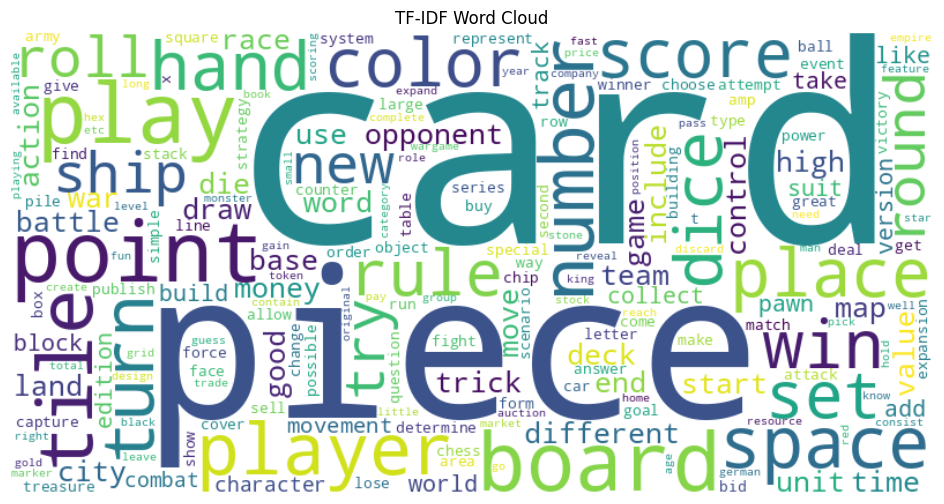

In [13]:
# Total TF-IDF score per term across all documents
tfidf_term_scores = X_tfidf_gensim.sum(axis=0)

# Map term to score
word_freq = {dictionary[i]: tfidf_term_scores[i] for i in range(num_terms)}

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate_from_frequencies(word_freq)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Word Cloud')
plt.show()

#### GloVe and Doc2Vec

In [14]:
# Load pretrained GloVe
w2v_model = gensim.downloader.load("glove-wiki-gigaword-100")

def get_avg_vector(doc):
    words = doc.split()
    vectors = [w2v_model[word] for word in words if word in w2v_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# Create document embeddings
X_w2v = np.vstack(df["clean_description"].apply(get_avg_vector))

[==================================================] 100.0% 128.1/128.1MB downloaded


In [15]:
# Prepare data
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df["clean_description"])]

# Train
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=40)

# Vectorize
X_doc2vec = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])

#### LDA

In [16]:
corpus = df['clean_description'].tolist()

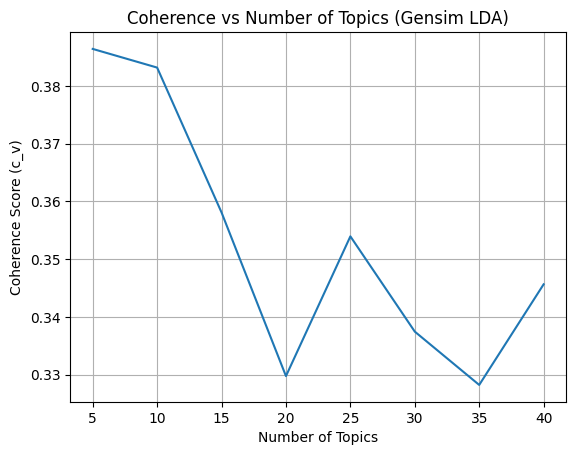

In [17]:
# Try different numbers of topics
coherence_scores = []
models = []
for k in range(5, 41, 5):
    model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=k, passes=15, random_state=42)
    coherence = CoherenceModel(model=model, texts=tokenized_descr, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_scores.append(coherence)
    models.append(model)

# Plot coherence vs. topic count
import matplotlib.pyplot as plt
plt.plot(range(5, 41, 5), coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs Number of Topics (Gensim LDA)")
plt.grid(True)
plt.show()

# Select best model
best_k = range(5, 41, 5)[np.argmax(coherence_scores)]
best_model = models[np.argmax(coherence_scores)]

In [18]:
for topic_id, words in best_model.show_topics(num_topics=best_k, num_words=10, formatted=False):
    print(f"Topic {topic_id}: {[word for word, prob in words]}")

Topic 0: ['card', 'player', 'game', 'play', 'point', 'turn', 'win', 'number', 'hand', 'place']
Topic 1: ['player', 'game', 'card', 'play', 'ship', 'turn', 'board', 'win', 'control', 'point']
Topic 2: ['game', 'player', 'piece', 'board', 'play', 'card', 'turn', 'space', 'dice', 'opponent']
Topic 3: ['game', 'player', 'play', 'board', 'card', 'money', 'buy', 'try', 'time', 'answer']
Topic 4: ['game', 'player', 'rule', 'war', 'play', 'board', 'card', 'battle', 'include', 'new']


In [19]:
beta_matrix = np.array(best_model.get_topics())
print("Beta shape:", beta_matrix.shape)

Beta shape: (5, 12254)


In [20]:
words = [dictionary[i] for i in range(len(dictionary))]

# We create a dataframe to read the results better
beta_df = pd.DataFrame(beta_matrix, columns=words, index=[f"Topic {i}" for i in range(best_k)])

# Here we display the top words per topic (beta vectors), with the probabilities.
for topic_id in range(best_k):
    print(f"\nTopic {topic_id}:")
    print(beta_df.iloc[topic_id].sort_values(ascending=False).head(10))


Topic 0:
card      0.070787
player    0.056440
game      0.024004
play      0.018864
point     0.015578
turn      0.010254
win       0.009941
number    0.009410
hand      0.009311
place     0.009307
Name: Topic 0, dtype: float32

Topic 1:
player     0.031329
game       0.020814
card       0.010239
play       0.006979
ship       0.005850
turn       0.005819
board      0.005178
win        0.004594
control    0.004512
point      0.004503
Name: Topic 1, dtype: float32

Topic 2:
game        0.034486
player      0.023204
piece       0.017545
board       0.013036
play        0.010964
card        0.009282
turn        0.006927
space       0.006529
dice        0.006439
opponent    0.006264
Name: Topic 2, dtype: float32

Topic 3:
game      0.029572
player    0.017554
play      0.005912
board     0.004935
card      0.004556
money     0.004085
buy       0.003713
try       0.003293
time      0.003282
answer    0.003272
Name: Topic 3, dtype: float32

Topic 4:
game       0.034918
player     0.021183


In [21]:
best_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

# igual usar esto que es más compacto

[(0,
  '0.071*"card" + 0.056*"player" + 0.024*"game" + 0.019*"play" + 0.016*"point" + 0.010*"turn" + 0.010*"win" + 0.009*"number" + 0.009*"hand" + 0.009*"place"'),
 (1,
  '0.031*"player" + 0.021*"game" + 0.010*"card" + 0.007*"play" + 0.006*"ship" + 0.006*"turn" + 0.005*"board" + 0.005*"win" + 0.005*"control" + 0.005*"point"'),
 (2,
  '0.034*"game" + 0.023*"player" + 0.018*"piece" + 0.013*"board" + 0.011*"play" + 0.009*"card" + 0.007*"turn" + 0.007*"space" + 0.006*"dice" + 0.006*"opponent"'),
 (3,
  '0.030*"game" + 0.018*"player" + 0.006*"play" + 0.005*"board" + 0.005*"card" + 0.004*"money" + 0.004*"buy" + 0.003*"try" + 0.003*"time" + 0.003*"answer"'),
 (4,
  '0.035*"game" + 0.021*"player" + 0.007*"rule" + 0.007*"war" + 0.006*"play" + 0.005*"board" + 0.005*"card" + 0.005*"battle" + 0.005*"include" + 0.004*"new"')]

In [22]:
theta_matrix = []
for doc in bow_corpus:
    doc_topics = best_model.get_document_topics(doc, minimum_probability=0)
    theta_matrix.append([prob for _, prob in doc_topics])

theta_matrix = np.array(theta_matrix)
print("Theta shape:", theta_matrix.shape)

Theta shape: (1783, 5)


In [23]:
# Dataframe for the thetas
theta_df = pd.DataFrame(theta_matrix, columns=[f"Topic {i}" for i in range(best_k)])

# We just display the most relevant topic (the one with the highest probability)
theta_df["Dominant Topic"] = theta_df.idxmax(axis=1)

print(theta_df[["Dominant Topic"]])

     Dominant Topic
0           Topic 4
1           Topic 0
2           Topic 0
3           Topic 2
4           Topic 3
...             ...
1778        Topic 2
1779        Topic 2
1780        Topic 0
1781        Topic 4
1782        Topic 2

[1783 rows x 1 columns]


In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.156096 -0.010808       1        1  28.699987
4      0.085874  0.037141       2        1  25.048644
2      0.010144  0.074635       3        1  20.016184
1      0.006401  0.004524       4        1  14.914691
3      0.053677 -0.105492       5        1  11.320493, topic_info=       Term         Freq        Total Category  logprob  loglift
64     card  3688.000000  3688.000000  Default  30.0000  30.0000
377   piece   628.000000   628.000000  Default  29.0000  29.0000
44    score   447.000000   447.000000  Default  28.0000  28.0000
33   player  4764.000000  4764.000000  Default  27.0000  27.0000
14     game  4209.000000  4209.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
315   start    45.738545   393.176452   Topic5  -5.8844   0.0272
494    lose    40.004749   180.624597   Topic5  -6.0184   0.6711
411    turn    46.608779   908.986710   Topic5  -5.8656  -0.7920
6       die    41.281611   281.149189   Topic5  -5.9869   0.2601
11      end    40.877688   488.909665   Topic5  -5.9968  -0.3030

[426 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
674       1  0.336368    action
674       2  0.198083    action
674       3  0.145759    action
674       4  0.276569    action
674       5  0.044849    action
...     ...       ...       ...
9717      5  0.821485     zargo
6877      2  0.946616  zeppelin
2694      1  0.165274    zombie
2694      4  0.793314    zombie
4905      2  0.935881       zoo

[971 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

 ## Sentiment Analysis

In this case, we will be using a zero-shot model from Facebook. We need to be careful when using these models because:

*   They are trained on natural language, not preprocessed or lemmatized text.
*   They expect raw sentences to understand semantic tone.
*   They perform better when given more expressive and emotional content, which can get lost when lemmatizing everything.

Because of this, we need to preprocess again the game descriptions and use that new column for using the model that we have selected.

There is an important aspect to consider here, which is that zero-shot classification with large transformer models is computationally expensive and slow when done sequentially.

To optimize performance, we convert our data to a Hugging Face Dataset object, which allows us to apply classification in efficient batches. Batching not only reduces runtime significantly, but also allows the model to process multiple descriptions in parallel without affecting the accuracy of individual predictions.

As a result of the classification process, we introduced two new variables into our dataset: `predicted_emotion` and `predicted_vibe`. The former reflects the emotional or narrative mood of the game (e.g., dark, funny, nostalgic), while the latter characterizes the gameplay dynamics or player experience (e.g., strategic, cooperative, family-friendly).

In [27]:
def light_preprocessing(text):
    text = html.unescape(text)
    text = re.sub(r"<.*?>", " ", text)
    return text.strip()

df["light_description"] = df["description"].apply(light_preprocessing)

In [28]:
# Convert to Hugging Face dataset for fast
hf_dataset = Dataset.from_pandas(df[["light_description"]])

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define label sets
# Emotional tone: mood/vibe of the game
emotional_labels = [
    "funny", "dark", "happy", "serious", "nostalgic", "intense"
]

# Gameplay vibe: type/feel of gameplay
vibe_labels = [
    "strategic", "cooperative", "competitive", "family-friendly", "chaotic", "educational"
]

# Define classification functions
def classify_batch(batch):
    emotion_result = classifier(batch["light_description"], emotional_labels)
    vibe_result = classifier(batch["light_description"], vibe_labels)

    return {
        "predicted_emotion": [r["labels"][0] for r in emotion_result],
        "predicted_vibe": [r["labels"][0] for r in vibe_result]
    }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [29]:
# Apply with batching
hf_dataset = hf_dataset.map(classify_batch, batched=True, batch_size=8)

# Convert back to pandas
df["predicted_emotion"] = hf_dataset["predicted_emotion"]
df["predicted_vibe"] = hf_dataset["predicted_vibe"]

Map:   0%|          | 0/1783 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [30]:
df.to_csv("boardgames_3000_with_dual_tone.csv", sep=";", index=False)

In [31]:
num_examples = 100

for i in range(num_examples):
    name = df.iloc[i]["name"]
    description = df.iloc[i]["description"][:500]
    emotion = df.iloc[i]["predicted_emotion"]
    vibe = df.iloc[i]["predicted_vibe"]

    print(f"Game: {name}")
    print(f"Description:\n{description}...")
    print(f"Predicted Emotion: {emotion}")
    print(f"Predicted Vibe: {vibe}\n")

Game: Die Macher
Description:
Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Se...
Predicted Emotion: nostalgic
Predicted Vibe: competitive

Game: Dragonmaster
Description:
Dragonmaster is a trick-taking card game based on an older game called Coup d'&#195;&#137;tat. Each player is given a supply of plastic gems, which represent points. Each player will get to be the dealer for five different hands, with slightly different goals for each hand. After all cards have been dealt out, the dealer decides which hand best suits his or her current card

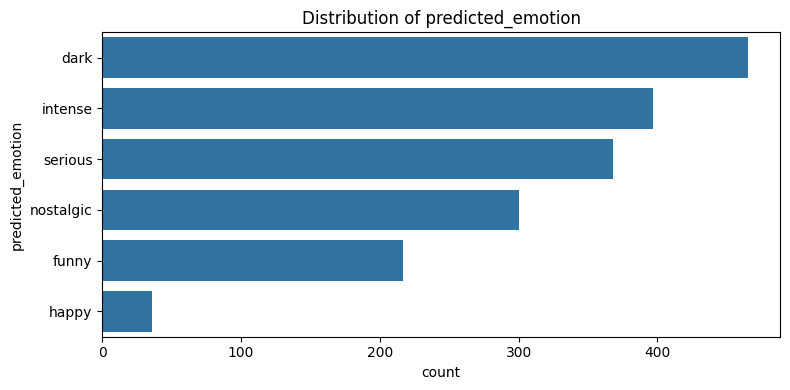

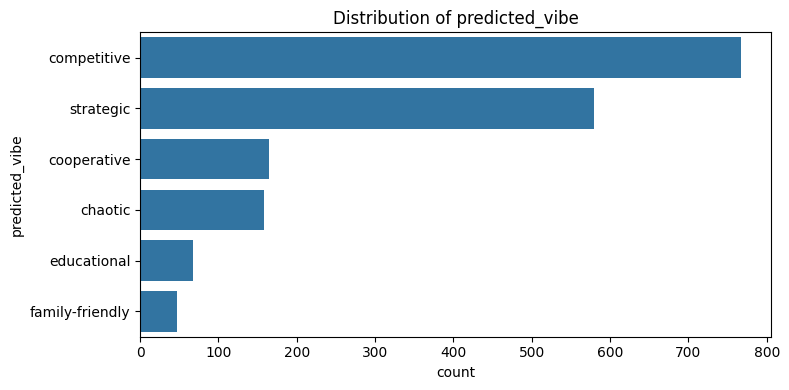

In [32]:
for col in ["predicted_emotion", "predicted_vibe"]:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

## Task 2: Machine Learning

### Task 2.1: Regression to predict the rating

In [86]:
#df = pd.read_csv("boardgames_3000_with_dual_tone.csv", sep=";")
#df.head()

In [87]:
# Set target variable
y = df["rating"].values

# GloVe embeddings matrix
def load_glove_embeddings(filepath="glove.6B.100d.txt"):
    embeddings = {}
    with open(filepath, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove = load_glove_embeddings("glove.6B.100d.txt")

def get_glove_vector(text, glove, dim=100):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

df["glove_vector"] = df["clean_description"].apply(lambda x: get_glove_vector(x, glove))

X_glove = np.vstack(df["glove_vector"])

# Metadata features
X_meta = df[["complexity", "year", "minplayers", "maxplayers", "playingtime", "minage"]].values

# One-hot encode for emotion + vibe
encoder = OneHotEncoder(drop="first", sparse_output=False)
X_tone = encoder.fit_transform(df[["predicted_emotion", "predicted_vibe"]])

In [88]:
# Feature names for future interpretation
glove_feat = [f"glove_{i}" for i in range(X_glove.shape[1])]
meta_feat = ["complexity", "year", "minplayers", "maxplayers", "playingtime", "minage"]
tone_feat = list(encoder.get_feature_names_out(["predicted_emotion", "predicted_vibe"]))
all_feat_names = glove_feat + meta_feat + tone_feat

In [89]:
# Helper functions
def train_and_evaluate(X, y, model_name="Model", regressor=None):
    if regressor is None:
        regressor = RandomForestRegressor(random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} - Test RMSE: {rmse:.4f}")
    plot_pred_vs_actual(y_test, y_pred, title=model_name)
    return regressor, mse, rmse

def plot_pred_vs_actual(y_true, y_pred, title="Prediction Plot"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    sns.lineplot(x=[y_true.min(), y_true.max()], y=[y_true.min(), y_true.max()], color='red', linestyle="--")
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title(f"{title}: Predicted vs Actual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importances(model, feature_names, top_n=20):
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
    plt.title("Top Feature Importances")
    plt.tight_layout()
    plt.show()

#### Performance without feature extraction/selection algorithms

ONLY METADATA

Metadata Only - Test RMSE: 1.1940


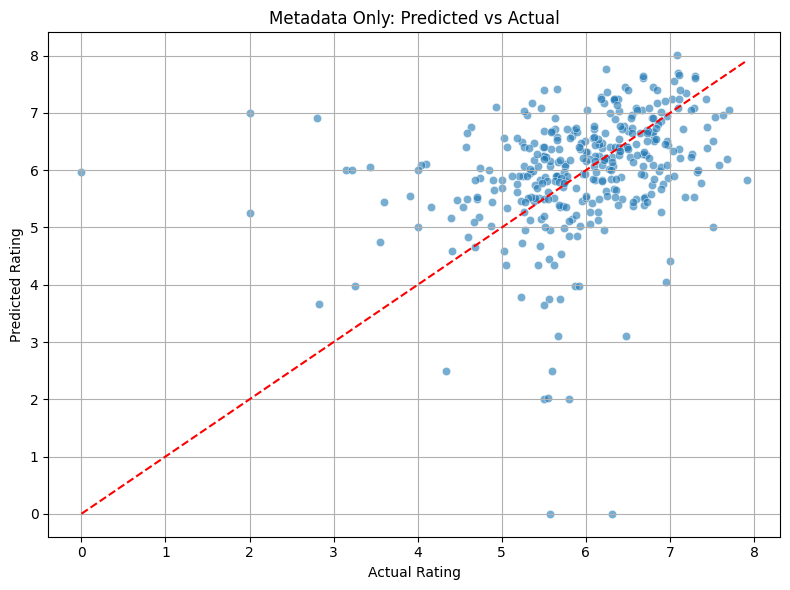

In [91]:
X_meta_full = np.hstack([X_meta, X_tone])
model_meta = train_and_evaluate(X_meta, y, model_name="Metadata Only", regressor=DecisionTreeRegressor(random_state=42))

METADATA + TF-IDF

TF-IDF + Metadata - Test RMSE: 0.8072


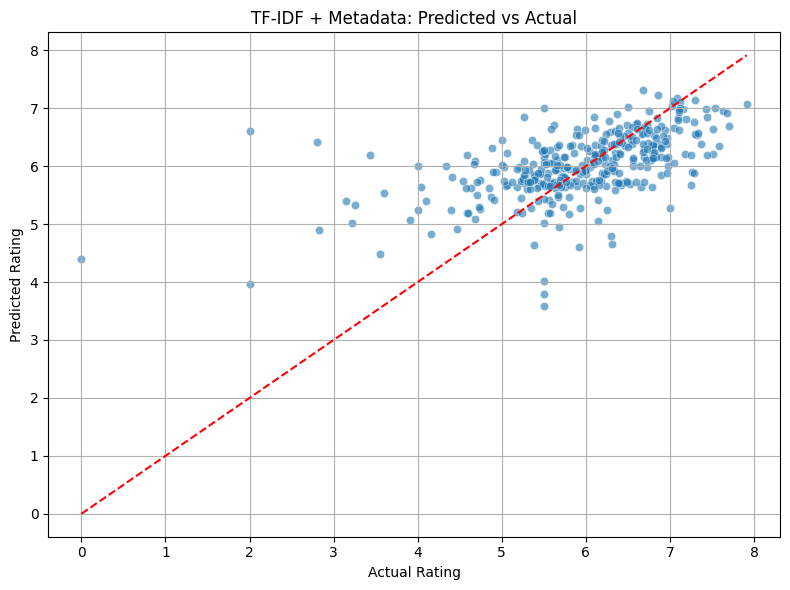

In [92]:
X_tfidf_meta = np.hstack([X_tfidf_gensim, X_meta, X_tone])
model_tfidf_meta = train_and_evaluate(X_tfidf_meta, y, model_name="TF-IDF + Metadata")

METADATA + GLOVE

Metadata + GloVe - Test RMSE: 0.7861


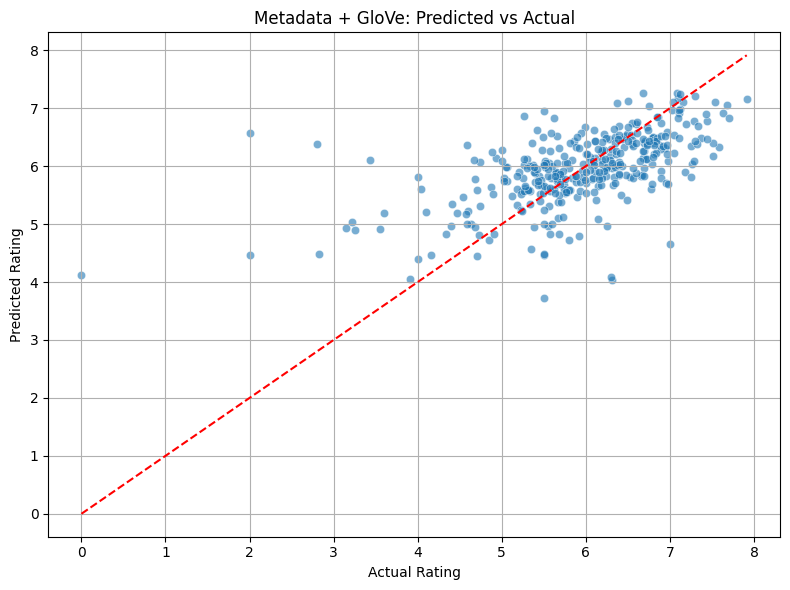

In [93]:
X_glove_meta = np.hstack([X_glove, X_meta, X_tone])
model_glove_meta = train_and_evaluate(X_glove_meta, y, model_name="Metadata + GloVe")

METADATA + DOC2VEC

Doc2Vec + Metadata - Test RMSE: 0.8344


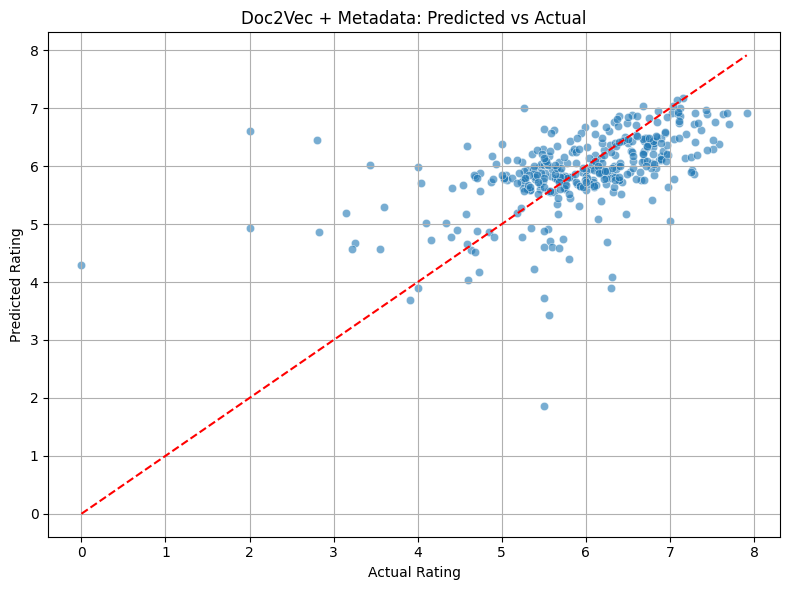

In [94]:
X_doc2vec_meta = np.hstack([X_doc2vec, X_meta, X_tone])
model_doc2vec_meta = train_and_evaluate(X_doc2vec_meta, y, model_name="Doc2Vec + Metadata")

METADATA + LDA

LDA + Metadata - Test RMSE: 0.8301


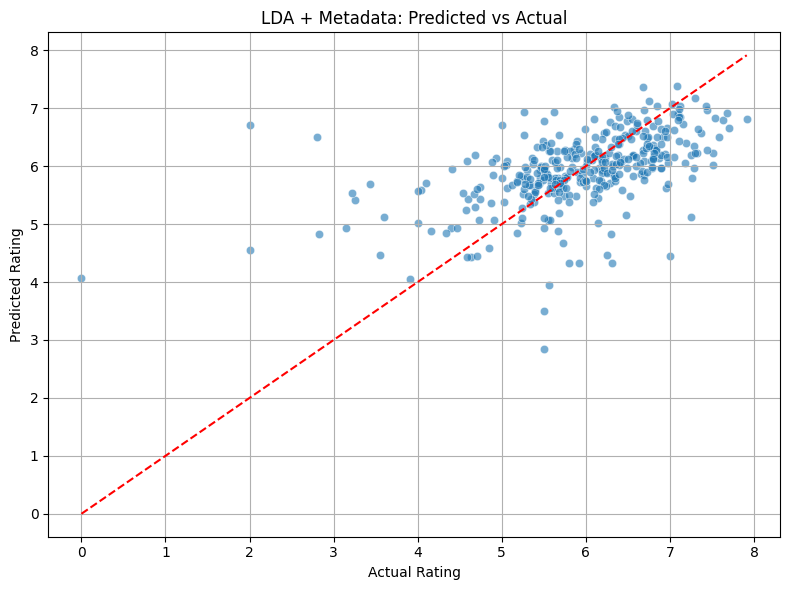

In [95]:
X_lda_meta = np.hstack([theta_matrix, X_meta, X_tone])
model_lda_meta = train_and_evaluate(X_lda_meta, y, model_name="LDA + Metadata")

In [96]:
rmse_results = {
    "Metadata Only": model_meta,
    "TF-IDF + Metadata": model_tfidf_meta,
    "GloVe + Metadata": model_glove_meta,
    "Doc2Vec + Metadata": model_doc2vec_meta,
    "LDA + Metadata": model_lda_meta
}

for name, (model, mse, rmse) in rmse_results.items():
    print(f"{name}: RMSE = {rmse:.4f}")

Metadata Only: RMSE = 1.1940
TF-IDF + Metadata: RMSE = 0.8072
GloVe + Metadata: RMSE = 0.7861
Doc2Vec + Metadata: RMSE = 0.8344
LDA + Metadata: RMSE = 0.8301


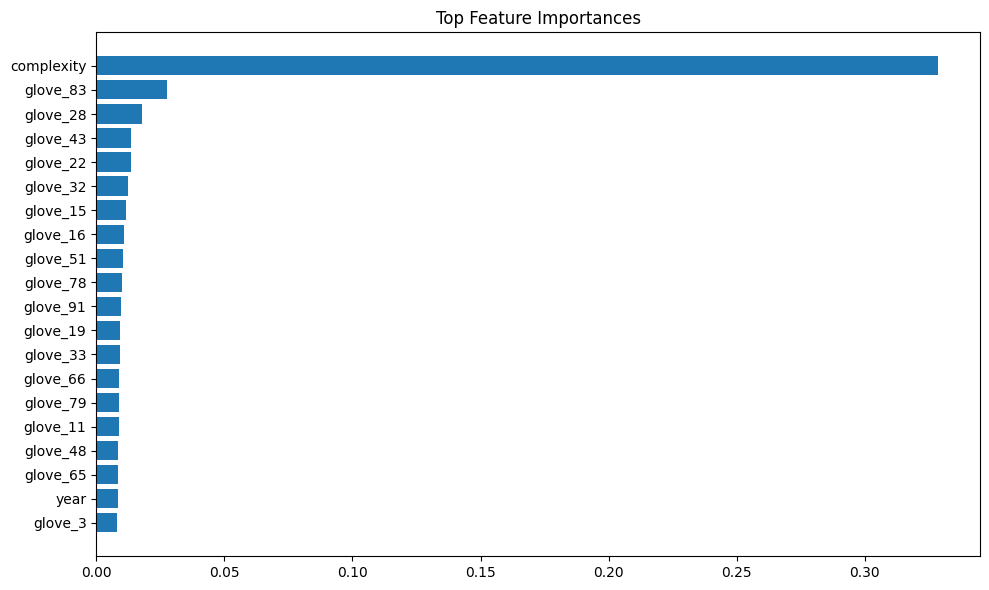

In [97]:
plot_feature_importances(model_glove_meta[0], all_feat_names)

#### Performance of the best model using more techniques

### Old version

Just with metadata complexity and year

In [ ]:

# Select only the 'complexity' and 'year' columns
X_metadata = df[["complexity", "year"]].values

# Target variable y
y = df["rating"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_metadata, y, test_size=0.2, random_state=42)

# Train a DecisionTree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and calculate MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

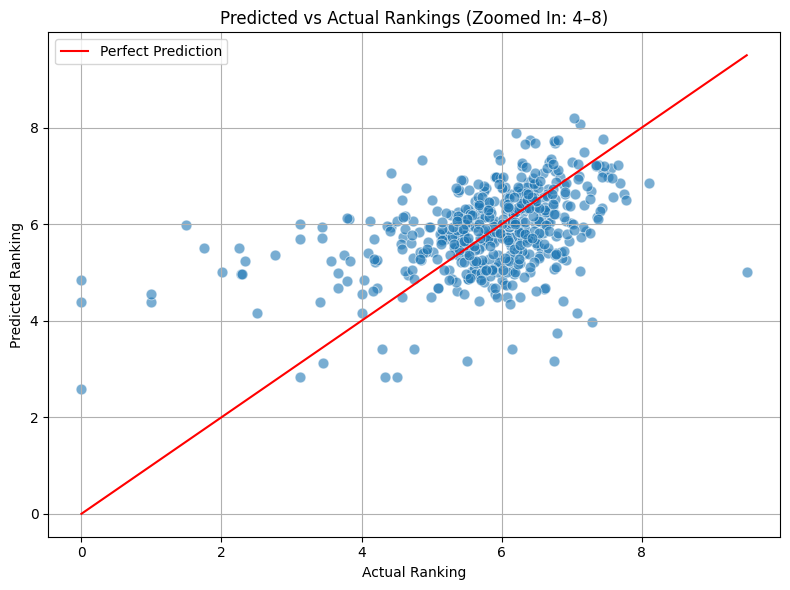

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Just with description embedded

In [ ]:
import pandas as pd
import numpy as np
import re
import html
import spacy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Load GloVe embeddings
def load_glove_embeddings(filepath="glove.6B.100d.txt"):
    embeddings = {}
    with open(filepath, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Convert a description to a GloVe vector
def get_glove_vector(text, glove, dim=100):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)


glove = load_glove_embeddings("glove.6B.100d.txt")


df["glove_vector"] = df["clean_description"].apply(lambda x: get_glove_vector(x, glove))

# Stack into matrix
X = np.vstack(df["glove_vector"].values)
y = df["rating"]  # Change this to your target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")


KeyboardInterrupt: 

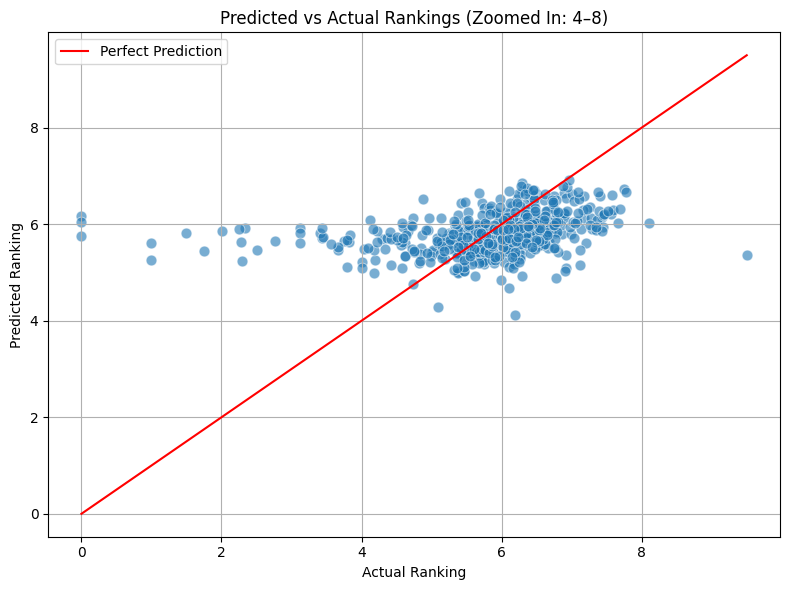

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now we use the other metadata complexity and year

In [ ]:
X_text = np.vstack(df["glove_vector"].values)
X_metadata = df[["complexity", "year"]].values
X = np.hstack([X_text, X_metadata])


y = df["rating"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest Regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and calculate MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")


Test MSE: 0.9093


It actually improves with the combination of the two

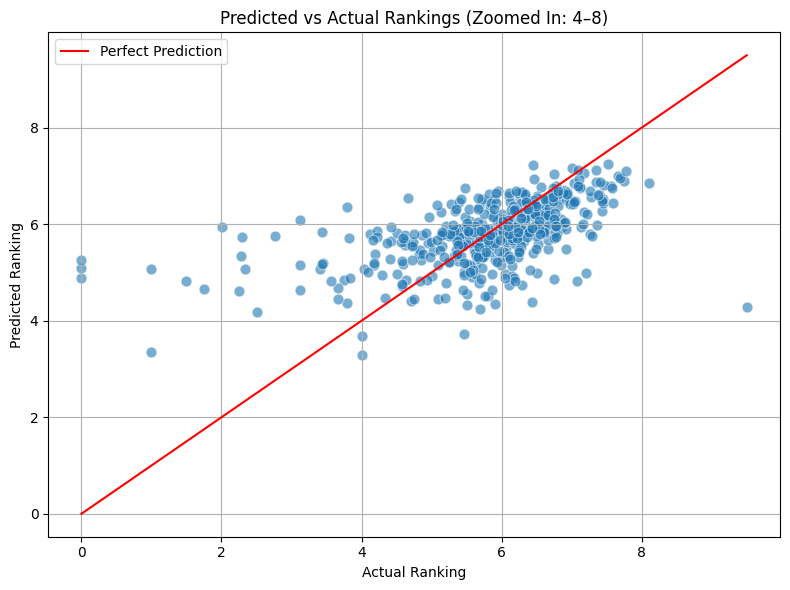

In [ ]:
# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now let's try with the tone predicted

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Create feature matrix X (including 'complexity', 'year' and 'predicted_tone' along with GloVe vectors)
X_text = np.vstack(df["glove_vector"].values)
X_metadata = df[["complexity", "year"]].values

# One-hot encode 'predicted_tone' if it's categorical
encoder = OneHotEncoder(drop='first')  # Drop first category to avoid multicollinearity
predicted_tone_encoded = encoder.fit_transform(df[["predicted_tone"]]).toarray()

# Combine all features
X = np.hstack([X_text, X_metadata, predicted_tone_encoded])

# Target variable y
y = df["rating"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest Regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and calculate MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")



Test MSE: 0.8936


It doesn't really improve much

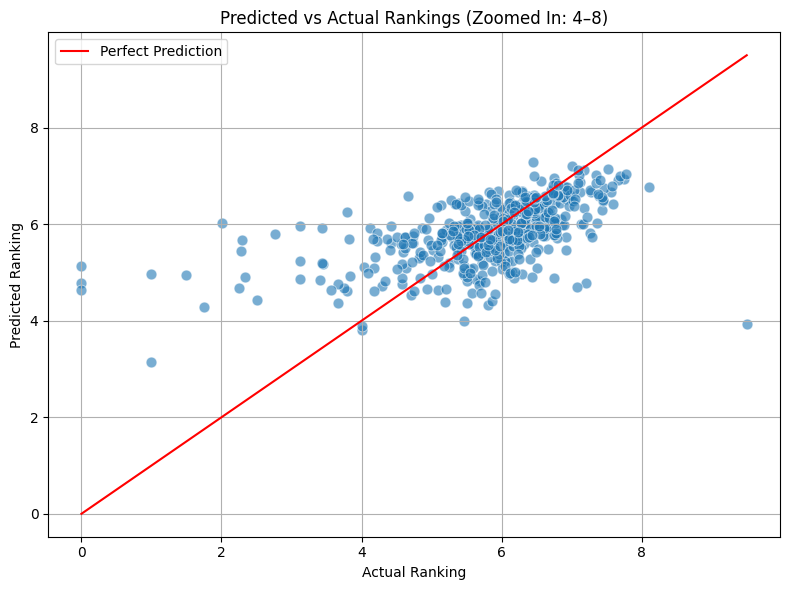

In [ ]:
# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


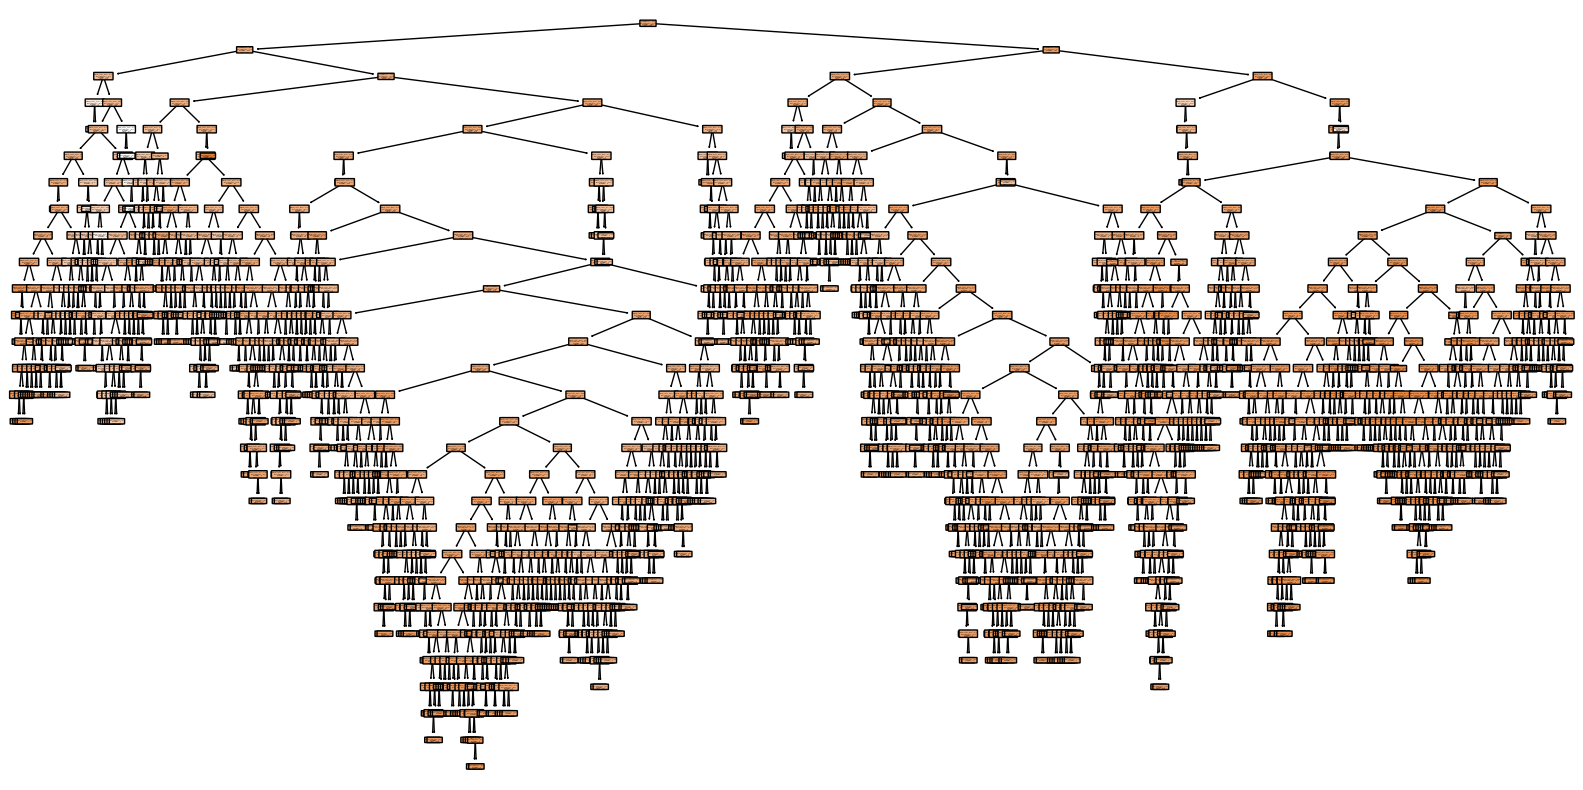

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], filled=True, feature_names=["glove_vector_" + str(i) for i in range(X_text.shape[1])] + ["complexity", "year"] + encoder.categories_[0].tolist(), class_names=["rating"], rounded=True, proportion=False, precision=2)
plt.show()

# qué barbaridad

### Task 2.1: Classification